
<img src="https://minas.medellin.unal.edu.co/eventos/latwaves2018/images/logo_unal.png" alt="unal logo" width="500"/>

#**Trabajo Final de Maestría**
##Ingeniería de Sistemas y Computación - Perfil profundización.
Joan Gabriel Bofill Barrera

---




Inspirado en el trabajo de Jonathan Bown: https://www.kaggle.com/code/jonbown/feedback-prize-feature-engineering

In [1]:
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from keras.models import load_model #(necesaria?)
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from collections import Counter
from string import punctuation
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Importar los datos de drive
from google.colab import drive
from google.colab import files
import io
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Tesis/train.csv")

Mounted at /content/drive


In [3]:
#Base de datos original
df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


# **Análisis Exploratorio de los Datos**

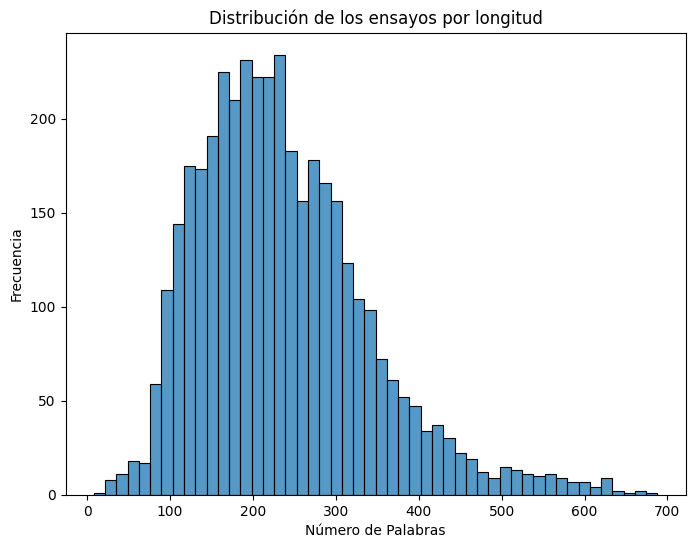

In [4]:
# Tokeniza los ensayos quitanto las stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['full_text'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Calcula la longitud de cada ensayo en palabras
df['word_count'] = df['tokens'].apply(len)

# Distribuación de los ensayos según su longitud
plt.figure(figsize=(8,6))
sns.histplot(df['word_count'], bins=50)
plt.title('Distribución de los ensayos por longitud')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

[('.', 69131), (',', 54877), ('people', 15305), ('students', 13118), ('school', 12938), ("n't", 9693), ('time', 8540), ('good', 8431), ('get', 8360), ('work', 8084), ('like', 8054), ('want', 7271), ('life', 7243), ('would', 7154), ('help', 6788), ('make', 6756), ('think', 6174), ("'s", 6102), ('one', 5751), ('also', 5194)]


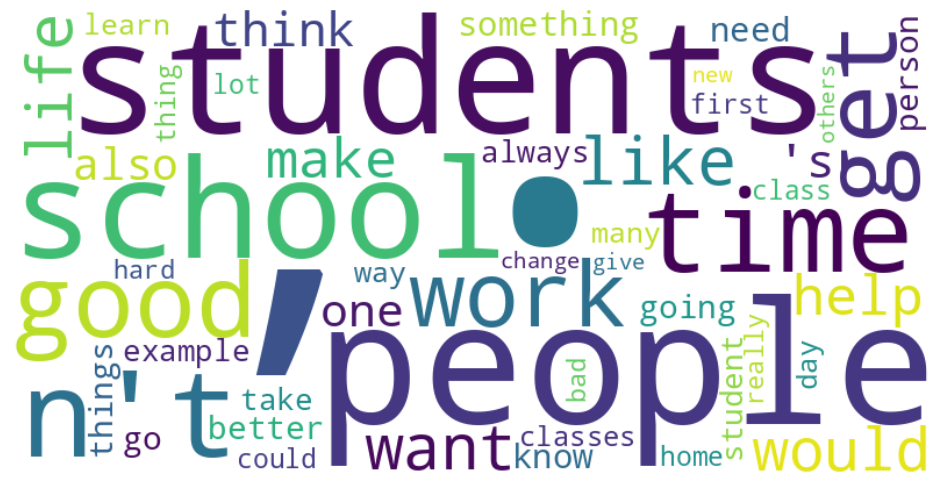

In [5]:
# Cuenta la frecuencia de cada palabra en los ensayos
word_counts = Counter(df['tokens'].sum())
print(word_counts.most_common(20))

# Visualiza las palabras más comunes word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

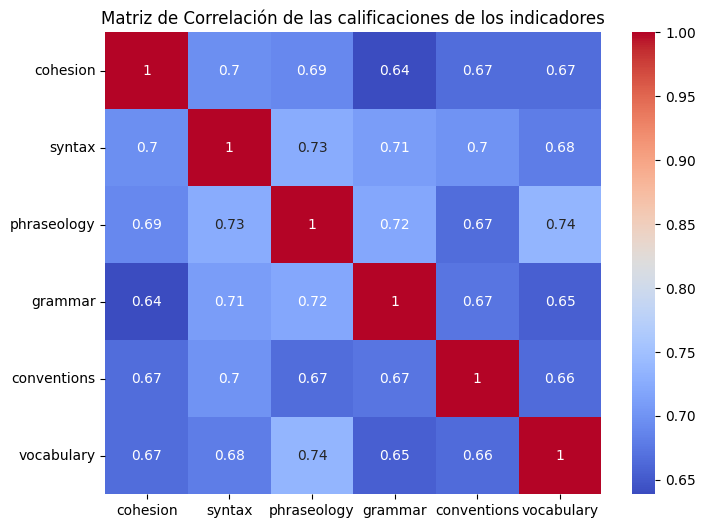

In [7]:
grades_df = df[['cohesion', 'syntax', 'phraseology', 'grammar', 'conventions', 'vocabulary']]

# Calcula la matriz de correlación de las notas
corr = grades_df.corr()

# Visualiza la matriz de correlación usando un mapa de calor
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de las calificaciones de los indicadores')
plt.show()

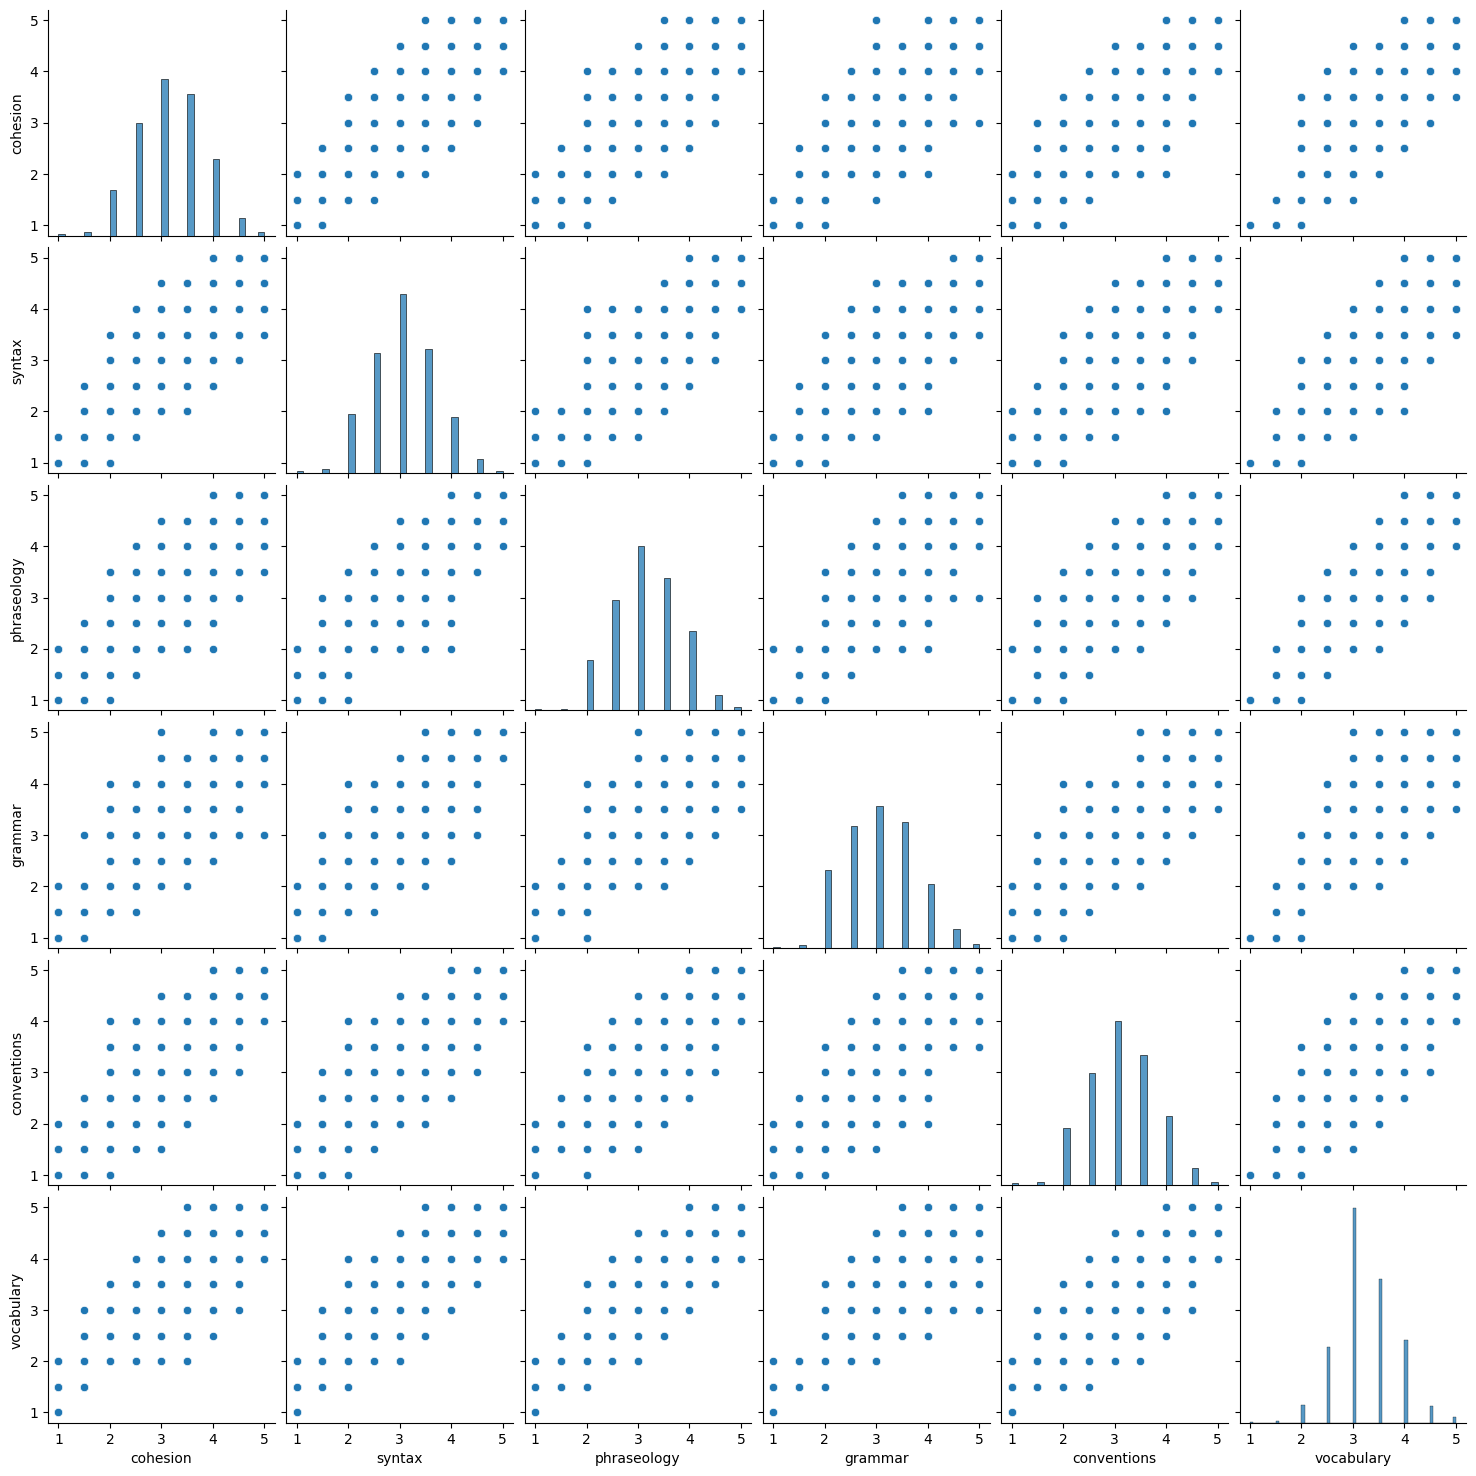

In [ ]:
# Visualiza la correlación entre notas usando scatterplots
sns.pairplot(grades_df)
plt.show()

In [ ]:
cohesion_counts = df['cohesion'].value_counts()
syntax_counts = df['syntax'].value_counts()
phraseology_counts = df['phraseology'].value_counts()
grammar_counts = df['grammar'].value_counts()
conventions_counts = df['conventions'].value_counts()
vocabulary_counts = df['vocabulary'].value_counts()

# Create a table of the value counts for each grade
counts_table = pd.DataFrame({
    'Syntax': syntax_counts,
    'Phraseology': phraseology_counts,
    'Grammar': grammar_counts,
    'Conventions': conventions_counts,
    'Vocabulary': vocabulary_counts
})

print(counts_table)

     Syntax  Phraseology  Grammar  Conventions  Vocabulary
1.0      11           10        8           15           2
1.5      29           11       20           20          14
2.0     410          350      544          402         124
2.5     839          772      855          784         528
3.0    1250         1153      994         1151        1503
3.5     867          929      880          908        1007
4.0     388          553      447          484         577
4.5     100          108      134          122         115
5.0      17           25       29           25          41


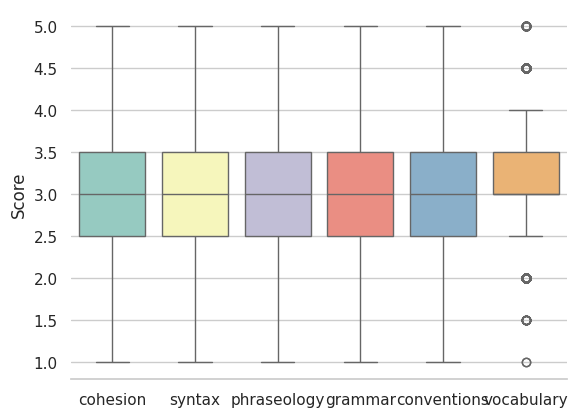

In [ ]:
columns = ['cohesion', 'syntax', 'phraseology', 'grammar', 'conventions', 'vocabulary']
sns.set(style="whitegrid")
sns.boxplot(data=df[columns], palette="Set3")
sns.despine(left=True)
plt.ylabel('Score')
plt.show()

In [ ]:
df['diff'] = [max(df['cohesion'][idx],df['syntax'][idx],df['vocabulary'][idx],df['cohesion'][idx],df['phraseology'][idx],df['grammar'][idx],df['conventions'][idx])-min(df['cohesion'][idx],df['syntax'][idx],df['vocabulary'][idx],df['cohesion'][idx],df['phraseology'][idx],df['grammar'][idx],df['conventions'][idx]) for idx in range(len(df['word_count']))]

<ipython-input-11-1d69e9f1bbd9>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis_data, y_axis_data, 'ro-', color='red', alpha=0.8, linewidth=1)


Text(0, 0.5, 'num')

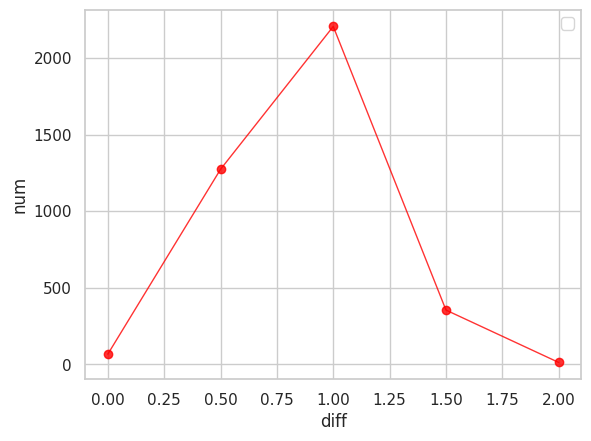

In [ ]:
plt.figure(0)
x_axis_data = np.linspace(0,2,5,endpoint=True)
y_axis_data = [sum (df['diff'][:] == score) for score in x_axis_data]
plt.plot(x_axis_data, y_axis_data, 'ro-', color='red', alpha=0.8, linewidth=1)
plt.legend(loc="upper right")
plt.xlabel('diff')
plt.ylabel('num')

# **Extracción de Características**

## Letras Mayúsculas

In [ ]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [ ]:
var = 'n_capital'
df[var]=df['full_text'].apply(count_capital_words)

## Puntuación

In [ ]:
def count_punctuations(text):
    punctuations="'!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'"
    count=0
    for i in punctuations:
        count+=text.count(i)
    return count

In [ ]:
var = 'n_punct'
df[var]=df['full_text'].apply(count_punctuations)

## Errores de Ortografía

In [ ]:
def count_spelling_errors(text):
  lst = [word.lower() for word in word_tokenize(text)]
  mistakes = 0
  for x in lst:
    a = TextBlob(x)
    if (a.correct() != x):
      mistakes = mistakes + 1
  return mistakes

In [ ]:
df['spelling_errors'] = df['full_text'].apply(count_spelling_errors)

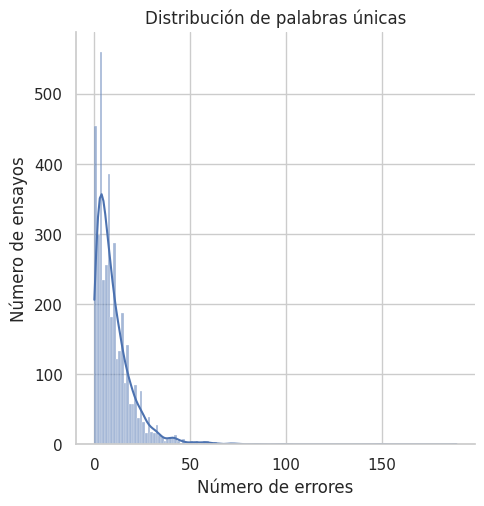

In [ ]:
var = 'spelling_errors'
plt.figure(figsize=(5,20))
sns.displot(data=df,x=var,kde="True")
plt.title('Distribución de palabras únicas')
plt.ylabel('Número de ensayos')
plt.xlabel('Número de errores')
plt.show()

## Número de Palabras Únicas

In [ ]:
def n_unique_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    unique_words = np.unique(words)
    return len(unique_words)

In [ ]:
var = 'n_unique'
df[var]=df['full_text'].apply(n_unique_words)

<Figure size 500x2000 with 0 Axes>

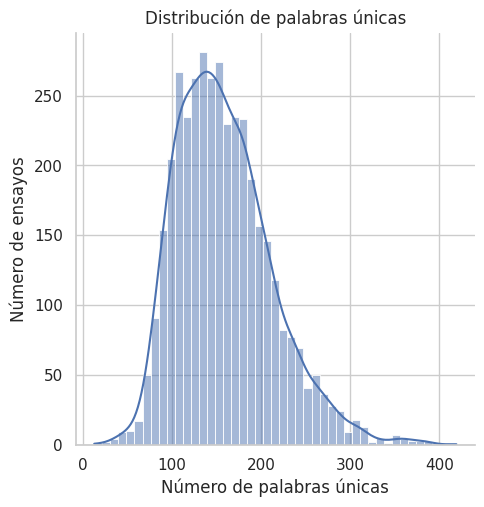

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x=var,kde="True")
plt.title('Distribución de palabras únicas')
plt.ylabel('Número de ensayos')
plt.xlabel('Número de palabras únicas')
plt.show()

## Número de palabras únicas excluyendo las stopwords

In [ ]:
def n_unique_words_no_stop(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    #remove stop words
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [ ]:
var = 'n_unique_n_stop'
df[var]=df['full_text'].apply(n_unique_words_no_stop)

<Figure size 500x2000 with 0 Axes>

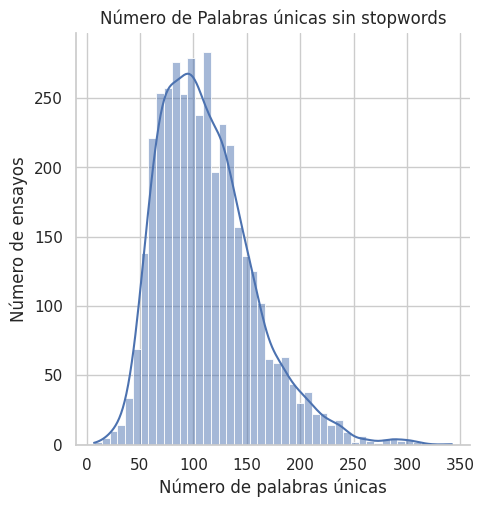

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x=var,kde="True")
plt.title('Número de Palabras únicas sin stopwords')
plt.ylabel('Número de ensayos')
plt.xlabel('Número de palabras únicas')
plt.show()

## Número de palabras con una sola letra

In [ ]:
def n_non_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = ['a', 'i', ' ']
    #remove stop words
    words = [word for word in words if len(word) == 1]
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [ ]:
var = 'n_n_word'
df[var]=df['full_text'].apply(n_non_words)

<Figure size 500x2000 with 0 Axes>

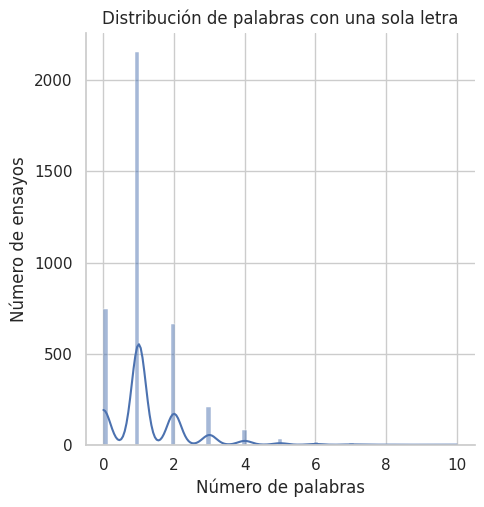

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x=var,kde="True")
plt.title('Distribución de palabras con una sola letra')
plt.ylabel('Número de ensayos')
plt.xlabel('Número de palabras')
plt.show()

## Número de Frases Nominales

In [ ]:
def count_noun_phrases(text):
    blob = TextBlob(text)
    return len(blob.noun_phrases)

In [ ]:
var = 'noun_phrase_count'
df[var]=df['full_text'].apply(count_noun_phrases)

<Figure size 500x2000 with 0 Axes>

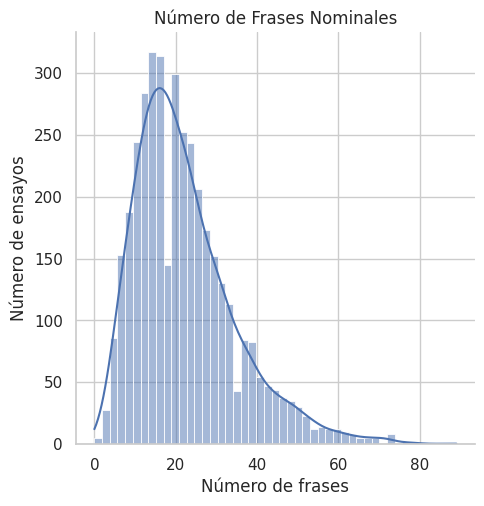

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x=var,kde="True")
plt.title('Número de Frases Nominales')
plt.ylabel('Número de ensayos')
plt.xlabel('Número de frases')
plt.show()

## Partes del Discurso

In [ ]:
def pos(text):
    doc = nlp(text)
    result = dict(Counter([t.pos_ for t in doc]))
    missing = set(var) - set(result.keys())
    for miss in missing:
        result[miss] = np.nan
    return pd.Series(result)

In [ ]:
var = ['PRON', 'VERB',	'SCONJ', 'NOUN', 'AUX', 'ADP', 'PUNCT', 'PART',	'CCONJ', 'ADV', 'DET', 'ADJ', 'SPACE', 'PROPN', 'NUM', 'INTJ', 'SYM', 'X']
df[var]=df['full_text'].apply(pos)

## Distribuciones

<Figure size 500x2000 with 0 Axes>

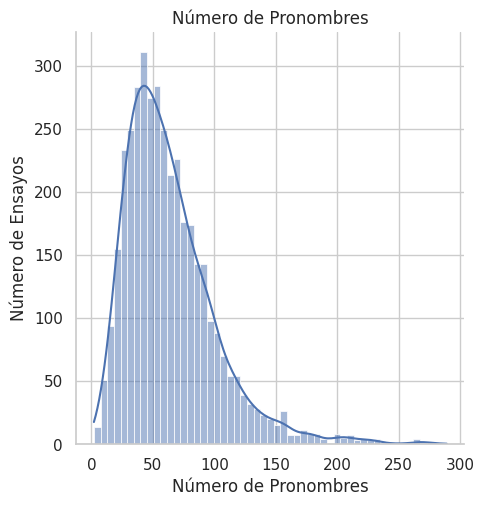

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x='PRON',kde="True")
plt.title('Número de Pronombres')
plt.ylabel('Número de Ensayos')
plt.xlabel('Número de Pronombres')
plt.show()

<Figure size 500x2000 with 0 Axes>

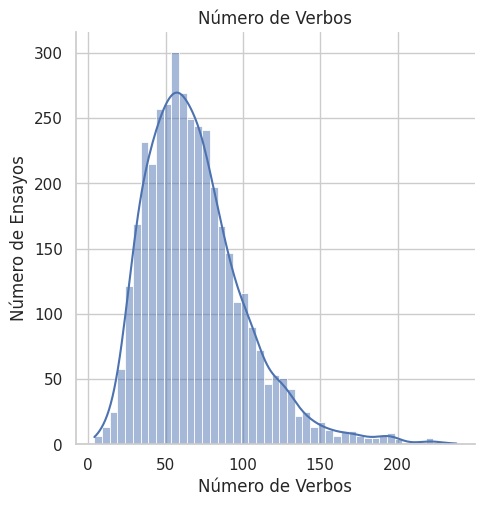

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x='VERB',kde="True")
plt.title('Número de Verbos')
plt.ylabel('Número de Ensayos')
plt.xlabel('Número de Verbos')
plt.show()

In [ ]:
df = df.fillna(0.0)

## Polaridad

In [ ]:
def essay_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [ ]:
var = 'polarity'
df[var]=df['full_text'].apply(essay_polarity)

## Subjetividad

In [ ]:
def essay_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [ ]:
var = 'subjectivity'
df[var]=df['full_text'].apply(essay_subjectivity)

## Gramática

In [ ]:
def spell_similarity(text):
    b = nlp(TextBlob(text).correct().string)
    return nlp(text).similarity(b)

In [ ]:
df['spell_score']=df['full_text'].apply(spell_similarity)

<ipython-input-46-383da46a5274>:3: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return nlp(text).similarity(b)


In [ ]:
column_names = df.columns.tolist()
print(column_names)

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'tokens', 'word_count', 'diff', 'n_capital', 'n_punct', 'spelling_errors', 'n_unique', 'n_unique_n_stop', 'n_n_word', 'noun_phrase_count', 'PRON', 'VERB', 'SCONJ', 'NOUN', 'AUX', 'ADP', 'PUNCT', 'PART', 'CCONJ', 'ADV', 'DET', 'ADJ', 'SPACE', 'PROPN', 'NUM', 'INTJ', 'SYM', 'X', 'polarity', 'subjectivity', 'spell_score']


## Estadística de Oraciones

In [ ]:
def sentence_av_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.mean(list(sent_len))

df['av_sent_len']=df['full_text'].apply(sentence_av_len_calc)

In [ ]:
def sentence_max_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.max(list(sent_len))

df['max_sent_len']=df['full_text'].apply(sentence_max_len_calc)

In [ ]:
def sentence_min_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.min(list(sent_len))

df['min_sent_len']=df['full_text'].apply(sentence_min_len_calc)


In [ ]:
def sentence_median_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.median(list(sent_len))

df['med_sent_len']=df['full_text'].apply(sentence_median_len_calc)

In [ ]:
def sentence_std_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.std(list(sent_len))

df['std_sent_len']=df['full_text'].apply(sentence_std_len_calc)

## Número de Oraciones

In [ ]:
def sentence_count(text):
    sentences = text.split(".")
    return len(sentences)

df['num_sent']=df['full_text'].apply(sentence_count)

<Figure size 500x2000 with 0 Axes>

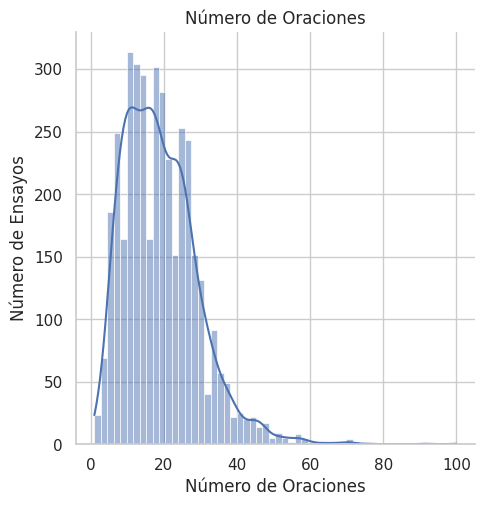

In [ ]:
plt.figure(figsize=(5,20))
sns.displot(data=df,x='num_sent',kde="True")
plt.title('Número de Oraciones')
plt.ylabel('Número de Ensayos')
plt.xlabel('Número de Oraciones')
plt.show()

## Puntuaciones de sentimiento

In [ ]:
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['full_text'].values):
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu
df['compound'],df['negative'],df['positive'],df['neutral']=generate_sentiment_scores(df)

100%|██████████| 3911/3911 [00:15<00:00, 252.60it/s]


## Longitud de caracteres

In [ ]:
df['char_len']=df['full_text'].apply(lambda x:len(x.split()))

# **Preprocesamiento**

In [ ]:
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
stop_words = stopwords.words('english')

In [ ]:
import string
import pandas as pd

def CleanFeatures(sentences, dictionary=apostrophe_dict, stop_words=set()):
    if not isinstance(sentences, pd.Series):
        raise ValueError("sentences debe ser una Serie de pandas.")

    # Reemplazo de palabras según el diccionario
    def replace_words(text):
        return ' '.join([dictionary.get(word.lower(), word) for word in text.split()])


    sentences = sentences.apply(replace_words)

    # Procesamiento y limpieza del texto
    sentences = sentences.apply(lambda sequence: ''.join([ltr.lower() for ltr in sequence if ltr not in string.punctuation]))
    sentences = sentences.apply(lambda sequence: ' '.join([word for word in sequence.split() if word not in stop_words]))
    return sentences

In [ ]:
df["full_text"] = CleanFeatures(df["full_text"])

In [ ]:
#BASIC TEXT CLEANING
def text_cleaner(text):
    text = text.strip() #Removes leading and trailing whitespaces from the text.
    text = re.sub(r'\n', ' ', text) #Replaces newline characters with a space.
    text = text.lower() #Converts the text to lowercase.
    return text

In [ ]:
df['full_text']=df['full_text'].apply(text_cleaner)

In [ ]:
df.drop('full_text_processed', axis=1, inplace=True)

In [ ]:
df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,diff,...,max_sent_len,min_sent_len,med_sent_len,std_sent_len,num_sent,compound,negative,positive,neutral,char_len
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,150,1.0,...,26,0,11.0,6.783963,19,0.9363,0.051,0.099,0.850,261
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,236,1.0,...,58,0,20.0,17.113997,15,-0.9194,0.111,0.091,0.798,533
2,00299B378633,dear principal if u change the school policy o...,3.0,3.5,3.0,3.0,3.0,2.5,169,1.0,...,26,0,16.0,5.943694,20,0.9271,0.054,0.110,0.837,320
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,390,1.0,...,35,0,16.0,7.272731,37,0.9995,0.054,0.242,0.704,728
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,115,0.5,...,85,0,26.5,31.148836,4,0.9868,0.000,0.164,0.836,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,i believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,107,1.0,...,53,2,21.5,16.031220,6,0.9252,0.081,0.138,0.781,179
3907,FFD9A83B0849,working alone students do not have to argue wi...,4.0,4.0,4.0,4.0,3.5,3.0,250,1.0,...,44,0,22.0,13.460438,17,0.9975,0.020,0.171,0.810,465
3908,FFDC4011AC9C,a problem is a chance for you to do your best ...,2.5,3.0,3.0,3.0,3.5,3.0,128,1.0,...,47,0,27.0,12.922243,8,-0.3901,0.147,0.135,0.718,257
3909,FFE16D704B16,many people disagree with albert schweitzers q...,4.0,4.5,4.5,4.0,4.5,4.5,278,0.5,...,65,10,20.0,14.787382,18,0.9977,0.045,0.172,0.784,510


# **Separar datos de entrenamiento y de prueba**

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8
test_ratio = 0.2
train, test = train_test_split(df, test_size= test_ratio, random_state=42)

#**Guardar las bases**


In [ ]:
from google.colab import files
df.to_csv('/content/drive/MyDrive/Tesis/Base_modificada.csv')
train.to_csv('/content/drive/MyDrive/Tesis/train_modificado.csv')
test.to_csv('/content/drive/MyDrive/Tesis/test_modificado.csv')